# ENSF 611 Final Project: Weather Temperature Prediction
## Improving Temperature Forecasts Using Machine Learning

**Group Members:** Cameron Dunn, Manuja Senanayake, Edmund Yu, Zohara Kamal

### Project Overview
This project aims to improve upon standard 24-hour advance temperature forecasts by analyzing the discrepancy between forecasted and observed temperatures in Calgary. We'll train and compare three regression models:
- Linear Regression (baseline)
- Support Vector Regressor (SVR)
- Gradient Boosting Regressor

### Objective
Can a machine learning model find trends in the discrepancy between forecasted weather 24hrs in advance and observed temperature such that it can use the forecast to produce more accurate temperature predictions?

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Machine Learning - Models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# Machine Learning - Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [2]:
# Load forecast data (24-hour advance predictions)
forecast_df = pd.read_csv('data/raw/forecast.csv', skiprows=2)

# Load observed temperature data
observed_df = pd.read_csv('data/raw/observed.csv', skiprows=2)

print(f"Forecast data shape: {forecast_df.shape}")
print(f"Observed data shape: {observed_df.shape}")
print("\nForecast data columns:")
print(forecast_df.columns.tolist())

Forecast data shape: (16080, 15)
Observed data shape: (16080, 2)

Forecast data columns:
['time', 'temperature_2m_previous_day1 (°C)', 'relative_humidity_2m_previous_day1 (%)', 'dew_point_2m_previous_day1 (°C)', 'apparent_temperature_previous_day1 (°C)', 'precipitation_previous_day1 (mm)', 'rain_previous_day1 (mm)', 'showers_previous_day1 (mm)', 'snowfall_previous_day1 (cm)', 'weather_code_previous_day1 (wmo code)', 'pressure_msl_previous_day1 (hPa)', 'surface_pressure_previous_day1 (hPa)', 'cloud_cover_previous_day1 (%)', 'wind_speed_10m_previous_day1 (km/h)', 'wind_direction_10m_previous_day1 (°)']


## 3. Checking out the data

In [3]:
# Display first few rows of forecast data
print("Forecast Data:")
display(forecast_df.head())

print("\nObserved Data:")
display(observed_df.head())

# Check data types
print("\nForecast Data Info:")
print(forecast_df.info())

print("\nObserved Data Info:")
print(observed_df.info())

Forecast Data:


,time,temperature_2m_previous_day1 (°C),relative_humidity_2m_previous_day1 (%),dew_point_2m_previous_day1 (°C),apparent_temperature_previous_day1 (°C),precipitation_previous_day1 (mm),rain_previous_day1 (mm),showers_previous_day1 (mm),snowfall_previous_day1 (cm),weather_code_previous_day1 (wmo code),pressure_msl_previous_day1 (hPa),surface_pressure_previous_day1 (hPa),cloud_cover_previous_day1 (%),wind_speed_10m_previous_day1 (km/h),wind_direction_10m_previous_day1 (°)
0,2024-01-01T00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01T01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01T02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01T03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01T04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Observed Data:


,time,temperature_2m (°C)
0,2024-01-01T00:00,3.2
1,2024-01-01T01:00,2.8
2,2024-01-01T02:00,2.6
3,2024-01-01T03:00,2.2
4,2024-01-01T04:00,1.9



Forecast Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16080 entries, 0 to 16079
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   time                                     16080 non-null  object 
 1   temperature_2m_previous_day1 (°C)        15636 non-null  float64
 2   relative_humidity_2m_previous_day1 (%)   15636 non-null  float64
 3   dew_point_2m_previous_day1 (°C)          15636 non-null  float64
 4   apparent_temperature_previous_day1 (°C)  15636 non-null  float64
 5   precipitation_previous_day1 (mm)         15636 non-null  float64
 6   rain_previous_day1 (mm)                  7902 non-null   float64
 7   showers_previous_day1 (mm)               15636 non-null  float64
 8   snowfall_previous_day1 (cm)              15636 non-null  float64
 9   weather_code_previous_day1 (wmo code)    15636 non-null  float64
 10  pressure_msl_previous_day

In [4]:
# Checking for missing values
print("Missing values in forecast data:")
print(forecast_df.isnull().sum())

print("\nMissing values in observed data:")
print(observed_df.isnull().sum())

Missing values in forecast data:
time                                          0
temperature_2m_previous_day1 (°C)           444
relative_humidity_2m_previous_day1 (%)      444
dew_point_2m_previous_day1 (°C)             444
apparent_temperature_previous_day1 (°C)     444
precipitation_previous_day1 (mm)            444
rain_previous_day1 (mm)                    8178
showers_previous_day1 (mm)                  444
snowfall_previous_day1 (cm)                 444
weather_code_previous_day1 (wmo code)       444
pressure_msl_previous_day1 (hPa)            444
surface_pressure_previous_day1 (hPa)        444
cloud_cover_previous_day1 (%)               444
wind_speed_10m_previous_day1 (km/h)         444
wind_direction_10m_previous_day1 (°)        444
dtype: int64

Missing values in observed data:
time                   0
temperature_2m (°C)    0
dtype: int64


In [5]:
# Basic statistics
print("Forecast Data Statistics:")
display(forecast_df.describe())

print("\nObserved Data Statistics:")
display(observed_df.describe())

Forecast Data Statistics:


,temperature_2m_previous_day1 (°C),relative_humidity_2m_previous_day1 (%),dew_point_2m_previous_day1 (°C),apparent_temperature_previous_day1 (°C),precipitation_previous_day1 (mm),rain_previous_day1 (mm),showers_previous_day1 (mm),snowfall_previous_day1 (cm),weather_code_previous_day1 (wmo code),pressure_msl_previous_day1 (hPa),surface_pressure_previous_day1 (hPa),cloud_cover_previous_day1 (%),wind_speed_10m_previous_day1 (km/h),wind_direction_10m_previous_day1 (°)
count,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,7902.000000,15636.0,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000
mean,6.847845,59.188923,-1.743541,3.466289,0.066436,0.067957,0.0,0.006585,7.170120,1014.141954,894.137305,67.899463,10.074354,205.674405
std,11.225072,21.182587,9.164973,12.235256,0.653012,0.748325,0.0,0.052957,17.950868,8.230116,7.305635,42.550855,6.472498,109.799991
min,-28.300000,9.000000,-34.800000,-33.800000,0.000000,0.000000,0.0,0.000000,0.000000,984.600000,866.600000,0.000000,0.000000,1.000000
25%,-0.300000,42.000000,-7.500000,-4.500000,0.000000,0.000000,0.0,0.000000,1.000000,1008.900000,889.700000,15.000000,5.500000,126.000000
50%,8.000000,59.000000,-1.400000,4.200000,0.000000,0.000000,0.0,0.000000,3.000000,1013.900000,894.800000,100.000000,8.400000,203.000000
75%,14.800000,77.000000,5.600000,12.500000,0.000000,0.000000,0.0,0.000000,3.000000,1019.100000,899.200000,100.000000,13.100000,307.000000
max,34.400000,100.000000,17.800000,34.900000,44.600000,44.500000,0.0,1.330000,95.000000,1049.900000,914.400000,100.000000,41.600000,360.000000



Observed Data Statistics:


,temperature_2m (°C)
count,16080.000000
mean,5.884428
std,11.929266
min,-39.100000
25%,-1.200000
50%,7.000000
75%,14.600000
max,33.600000


## 4. Data Cleaning and Preprocessing

In [6]:
# Convert time column to datetime
forecast_df['time'] = pd.to_datetime(forecast_df['time'])
observed_df['time'] = pd.to_datetime(observed_df['time'])

# Sort by time
forecast_df = forecast_df.sort_values('time').reset_index(drop=True)
observed_df = observed_df.sort_values('time').reset_index(drop=True)

print("Date range of forecast data:")
print(f"From: {forecast_df['time'].min()}")
print(f"To: {forecast_df['time'].max()}")

print("\nDate range of observed data:")
print(f"From: {observed_df['time'].min()}")
print(f"To: {observed_df['time'].max()}")

Date range of forecast data:
From: 2024-01-01 00:00:00
To: 2025-10-31 23:00:00

Date range of observed data:
From: 2024-01-01 00:00:00
To: 2025-10-31 23:00:00


In [ ]:
# Merge forecast and observed data on time
df = forecast_df.merge(observed_df, on='time', how='inner', suffixes=('_forecast', '_observed'))

In [ ]:
# Remove columns with more than 25% nulls
null_threshold = 0.25
cols_to_drop = df.columns[df.isnull().mean() > null_threshold]
df = df.drop(columns=cols_to_drop)
print(f"Removed columns with >{null_threshold * 100}% nulls: {list(cols_to_drop)}")

Removed columns with >25.0% nulls: ['rain_previous_day1 (mm)']


In [9]:
# Drop rows with missing values
df_clean = df.dropna()

## 5. Feature Engineering

### 5.1 Time Encoding (Hour, Day, Month)

In [10]:
# Extract time components
df_clean['hour'] = df_clean['time'].dt.hour
df_clean['day'] = df_clean['time'].dt.day
df_clean['month'] = df_clean['time'].dt.month
df_clean['day_of_year'] = df_clean['time'].dt.dayofyear
df_clean['day_of_week'] = df_clean['time'].dt.dayofweek

# Cyclical encoding for hour (0-23)
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

# Cyclical encoding for month (1-12)
df_clean['month_sin'] = np.sin(2 * np.pi * df_clean['month'] / 12)
df_clean['month_cos'] = np.cos(2 * np.pi * df_clean['month'] / 12)

print("Time features created")
print("\nNew time-based columns:")
print(['hour', 'day', 'month', 'day_of_year', 'day_of_week', 
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos'])

Time features created

New time-based columns:
['hour', 'day', 'month', 'day_of_year', 'day_of_week', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


### 5.2 Wind Direction Encoding (Cosine and Sine)

In [11]:
# Wind direction is in degrees (0-360)
# Convert to radians and apply sin/cos transformation
wind_col = 'wind_direction_10m_previous_day1 (°)'

if wind_col in df_clean.columns:
    df_clean['wind_dir_sin'] = np.sin(np.radians(df_clean[wind_col]))
    df_clean['wind_dir_cos'] = np.cos(np.radians(df_clean[wind_col]))
else:
    print(f"Warning: {wind_col} not found in dataset")

## 6. Visualization and Exploratory Data Analysis

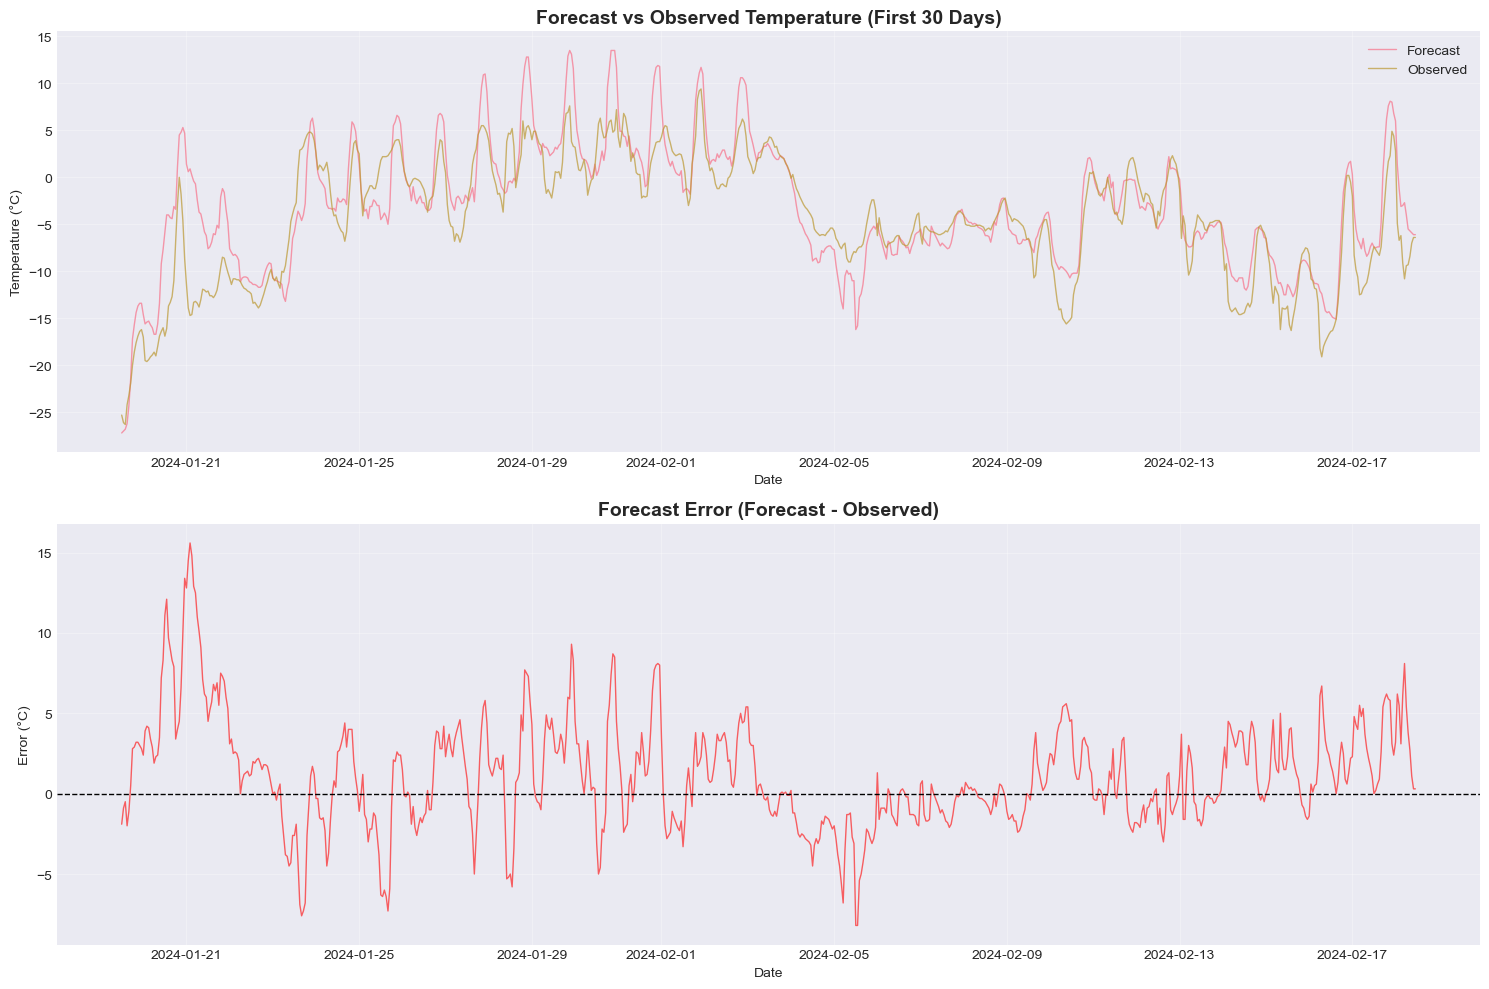

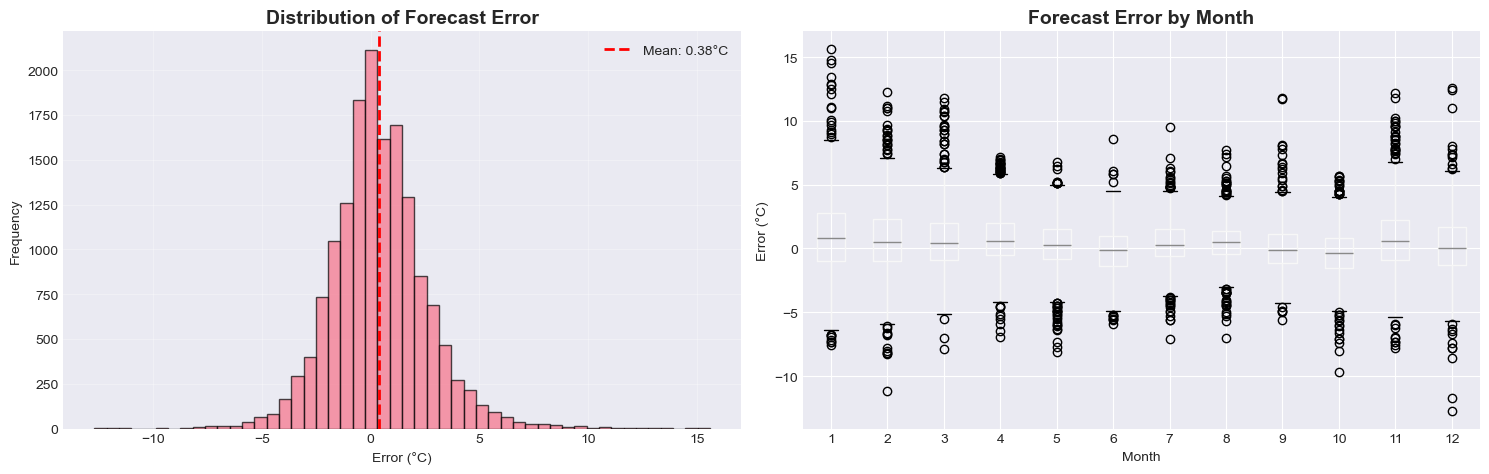

Mean Absolute Forecast Error: 1.65°C
RMSE of raw forecast: 2.23°C


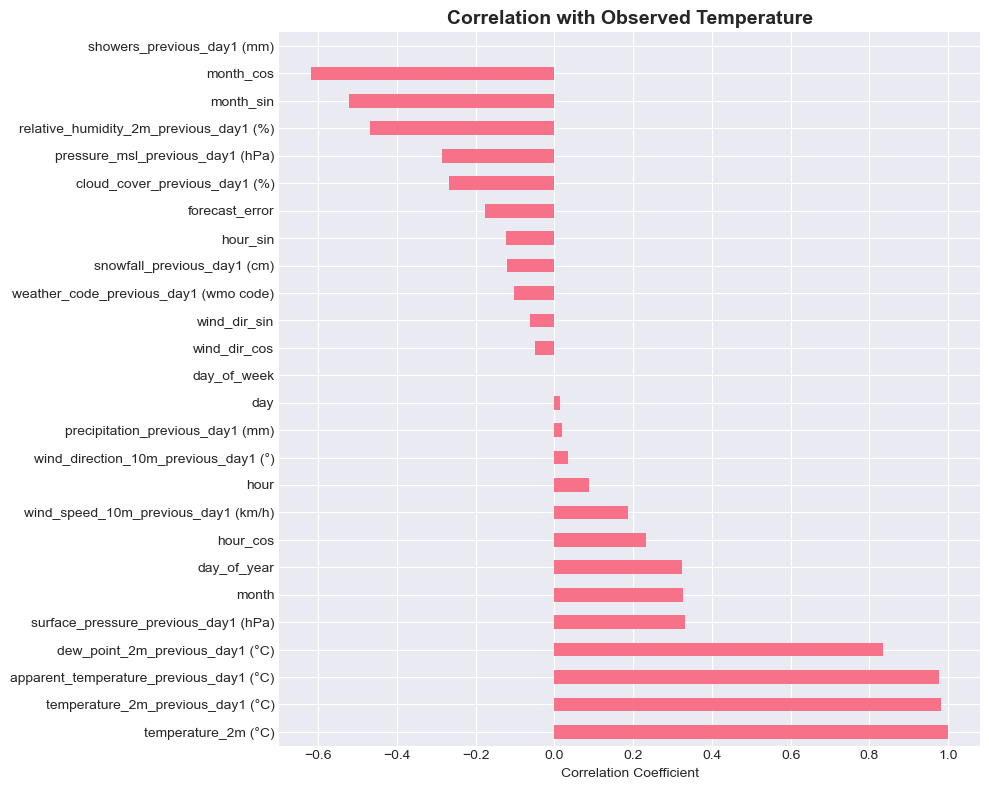


Top 10 features correlated with observed temperature:
temperature_2m (°C)                        1.000000
temperature_2m_previous_day1 (°C)          0.981216
apparent_temperature_previous_day1 (°C)    0.976378
dew_point_2m_previous_day1 (°C)            0.834901
surface_pressure_previous_day1 (hPa)       0.330716
month                                      0.327493
day_of_year                                0.324976
hour_cos                                   0.233822
wind_speed_10m_previous_day1 (km/h)        0.186007
hour                                       0.088922
dtype: float64


In [12]:
# Ensure forecast_error exists for EDA/plots (not used in modeling!)
df_clean['forecast_error'] = df_clean['temperature_2m_previous_day1 (°C)'] - df_clean['temperature_2m (°C)']

# Visualize temperature trends
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot first 30 days
sample_data = df_clean.head(24*30)  # First 30 days

axes[0].plot(sample_data['time'], sample_data['temperature_2m_previous_day1 (°C)'], 
             label='Forecast', alpha=0.7, linewidth=1)
axes[0].plot(sample_data['time'], sample_data['temperature_2m (°C)'], 
             label='Observed', alpha=0.7, linewidth=1)
axes[0].set_title('Forecast vs Observed Temperature (First 30 Days)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot forecast error
axes[1].plot(sample_data['time'], sample_data['forecast_error'], 
             color='red', alpha=0.6, linewidth=1)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Forecast Error (Forecast - Observed)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Error (°C)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution of forecast error
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df_clean['forecast_error'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df_clean['forecast_error'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"Mean: {df_clean['forecast_error'].mean():.2f}°C")
axes[0].set_title('Distribution of Forecast Error', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Error (°C)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by month
df_clean.boxplot(column='forecast_error', by='month', ax=axes[1])
axes[1].set_title('Forecast Error by Month', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Error (°C)')
plt.suptitle('')  # Remove the default title

plt.tight_layout()
plt.show()

print(f"Mean Absolute Forecast Error: {abs(df_clean['forecast_error']).mean():.2f}°C")
print(f"RMSE of raw forecast: {np.sqrt(mean_squared_error(df_clean['temperature_2m (°C)'], df_clean['temperature_2m_previous_day1 (°C)'])):.2f}°C")

# Correlation heatmap
# Select numeric columns for correlation
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
correlation_cols = [col for col in numeric_cols if col not in ['time']]

# Calculate correlation with target variable
target_corr = df_clean[correlation_cols].corrwith(df_clean['temperature_2m (°C)']).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
target_corr.plot(kind='barh')
plt.title('Correlation with Observed Temperature', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

print("\nTop 10 features correlated with observed temperature:")
print(target_corr.head(10))

## 7. Prepare Data for Modeling / Pipeline

In [13]:
# Use only the forecast as feature, and observed as target
feature_col = 'temperature_2m_previous_day1 (°C)'
target_col = 'temperature_2m (°C)'

X = df_clean[[feature_col]].copy()
y = df_clean[target_col].copy()


In [ ]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 8. Model Training and Evaluation

### 8.1 Helper Functions

In [16]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a model, returning performance metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results = {
        'Model': model_name,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'predictions': y_test_pred
    }
    
    return results

def cross_validate_model(model, X, y, cv=5):
    """
    Perform k-fold cross-validation
    """
    kfold = KFold(n_splits=cv, shuffle=False)
    
    mae_scores = -cross_val_score(model, X, y, cv=kfold, 
                                   scoring='neg_mean_absolute_error')
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=kfold, 
                                            scoring='neg_mean_squared_error'))
    
    return {
        'MAE_mean': mae_scores.mean(),
        'MAE_std': mae_scores.std(),
        'RMSE_mean': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std()
    }


### 8.2 Baseline Model: Linear Regression

In [ ]:
print("LINEAR REGRESSION (BASELINE)")


# Initialize and train
lr_model = LinearRegression()
lr_results = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Linear Regression')

# Print results
print(f"\nTraining Set Performance:")
print(f"  MAE:  {lr_results['Train MAE']:.4f}°C")
print(f"  RMSE: {lr_results['Train RMSE']:.4f}°C")
print(f"  R²:   {lr_results['Train R²']:.4f}")

print(f"\nTest Set Performance:")
print(f"  MAE:  {lr_results['Test MAE']:.4f}°C")
print(f"  RMSE: {lr_results['Test RMSE']:.4f}°C")
print(f"  R²:   {lr_results['Test R²']:.4f}")

# Cross-validation
print("\nPerforming 5-fold cross-validation...")
lr_cv_results = cross_validate_model(lr_model, X_train_scaled, y_train, cv=5)
print(f"Cross-validation MAE:  {lr_cv_results['MAE_mean']:.4f} (±{lr_cv_results['MAE_std']:.4f})°C")
print(f"Cross-validation RMSE: {lr_cv_results['RMSE_mean']:.4f} (±{lr_cv_results['RMSE_std']:.4f})°C")

LINEAR REGRESSION (BASELINE)

Training Set Performance:
  MAE:  1.7038°C
  RMSE: 2.2820°C
  R²:   0.9610

Test Set Performance:
  MAE:  1.4064°C
  RMSE: 1.8473°C
  R²:   0.9202

Performing 5-fold cross-validation...
Cross-validation MAE:  1.7178 (±0.2693)°C
Cross-validation RMSE: 2.2673 (±0.3817)°C


### 8.3 Support Vector Regressor

In [ ]:
print("=" * 60)
print("SUPPORT VECTOR REGRESSOR")
print("=" * 60)

# Initialize with default parameters first
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_results = evaluate_model(svr_model, X_train_scaled, X_test_scaled, y_train, y_test, 'SVR (default)')

# Print results
print(f"\nTraining Set Performance (default parameters):")
print(f"  MAE:  {svr_results['Train MAE']:.4f}°C")
print(f"  RMSE: {svr_results['Train RMSE']:.4f}°C")
print(f"  R²:   {svr_results['Train R²']:.4f}")

print(f"\nTest Set Performance (default parameters):")
print(f"  MAE:  {svr_results['Test MAE']:.4f}°C")
print(f"  RMSE: {svr_results['Test RMSE']:.4f}°C")
print(f"  R²:   {svr_results['Test R²']:.4f}")

SUPPORT VECTOR REGRESSOR

Training Set Performance (default parameters):
  MAE:  1.6858°C
  RMSE: 2.2720°C
  R²:   0.9613

Test Set Performance (default parameters):
  MAE:  1.3771°C
  RMSE: 1.8211°C
  R²:   0.9225


In [19]:
# Hyperparameter tuning with GridSearchCV
print("\nPerforming hyperparameter tuning...")
print("This may take several minutes...")

param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf', 'linear']
}

svr_grid = GridSearchCV(
    SVR(),
    param_grid_svr,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

svr_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {svr_grid.best_params_}")
print(f"Best cross-validation MAE: {-svr_grid.best_score_:.4f}°C")

# Evaluate best model
svr_best_results = evaluate_model(svr_grid.best_estimator_, X_train_scaled, X_test_scaled, 
                                  y_train, y_test, 'SVR (tuned)')

print(f"\nTest Set Performance (tuned parameters):")
print(f"  MAE:  {svr_best_results['Test MAE']:.4f}°C")
print(f"  RMSE: {svr_best_results['Test RMSE']:.4f}°C")
print(f"  R²:   {svr_best_results['Test R²']:.4f}")


Performing hyperparameter tuning...
This may take several minutes...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best parameters: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}
Best cross-validation MAE: 1.7126°C

Test Set Performance (tuned parameters):
  MAE:  1.3784°C
  RMSE: 1.8161°C
  R²:   0.9229


### 8.4 Gradient Boosting Regressor

In [20]:
print("=" * 60)
print("GRADIENT BOOSTING REGRESSOR")
print("=" * 60)

# Initialize with default parameters first
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_results = evaluate_model(gb_model, X_train_scaled, X_test_scaled, 
                           y_train, y_test, 'Gradient Boosting (default)')

# Print results
print(f"\nTraining Set Performance (default parameters):")
print(f"  MAE:  {gb_results['Train MAE']:.4f}°C")
print(f"  RMSE: {gb_results['Train RMSE']:.4f}°C")
print(f"  R²:   {gb_results['Train R²']:.4f}")

print(f"\nTest Set Performance (default parameters):")
print(f"  MAE:  {gb_results['Test MAE']:.4f}°C")
print(f"  RMSE: {gb_results['Test RMSE']:.4f}°C")
print(f"  R²:   {gb_results['Test R²']:.4f}")

GRADIENT BOOSTING REGRESSOR

Training Set Performance (default parameters):
  MAE:  1.6614°C
  RMSE: 2.2308°C
  R²:   0.9627

Test Set Performance (default parameters):
  MAE:  1.4159°C
  RMSE: 1.8656°C
  R²:   0.9186


In [21]:
# Hyperparameter tuning
print("\nPerforming hyperparameter tuning...")
print("This may take several minutes...")

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {gb_grid.best_params_}")
print(f"Best cross-validation MAE: {-gb_grid.best_score_:.4f}°C")

# Evaluate best model
gb_best_results = evaluate_model(gb_grid.best_estimator_, X_train_scaled, X_test_scaled, 
                                y_train, y_test, 'Gradient Boosting (tuned)')

print(f"\nTest Set Performance (tuned parameters):")
print(f"  MAE:  {gb_best_results['Test MAE']:.4f}°C")
print(f"  RMSE: {gb_best_results['Test RMSE']:.4f}°C")
print(f"  R²:   {gb_best_results['Test R²']:.4f}")


Performing hyperparameter tuning...
This may take several minutes...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation MAE: 1.7370°C

Test Set Performance (tuned parameters):
  MAE:  1.4147°C
  RMSE: 1.8647°C
  R²:   0.9187


## 9. Model Comparison and Results

In [22]:
# Compile results
results_df = pd.DataFrame([
    lr_results,
    svr_results,
    svr_best_results,
    gb_results,
    gb_best_results
]).drop(columns=['predictions'])

print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
display(results_df)

# Find best model
best_model_idx = results_df['Test MAE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"\n Best Model: {best_model_name}")
print(f"   Test MAE:  {results_df.loc[best_model_idx, 'Test MAE']:.4f}°C")
print(f"   Test RMSE: {results_df.loc[best_model_idx, 'Test RMSE']:.4f}°C")


MODEL COMPARISON SUMMARY


,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,Linear Regression,1.703768,1.406370,2.281968,1.847344,0.960971,0.920220
1,SVR (default),1.685793,1.377149,2.271998,1.821110,0.961311,0.922470
2,SVR (tuned),1.700812,1.378360,2.285563,1.816126,0.960848,0.922894
3,Gradient Boosting (default),1.661429,1.415854,2.230783,1.865571,0.962702,0.918638
4,Gradient Boosting (tuned),1.662825,1.414711,2.231303,1.864659,0.962685,0.918718



 Best Model: SVR (default)
   Test MAE:  1.3771°C
   Test RMSE: 1.8211°C


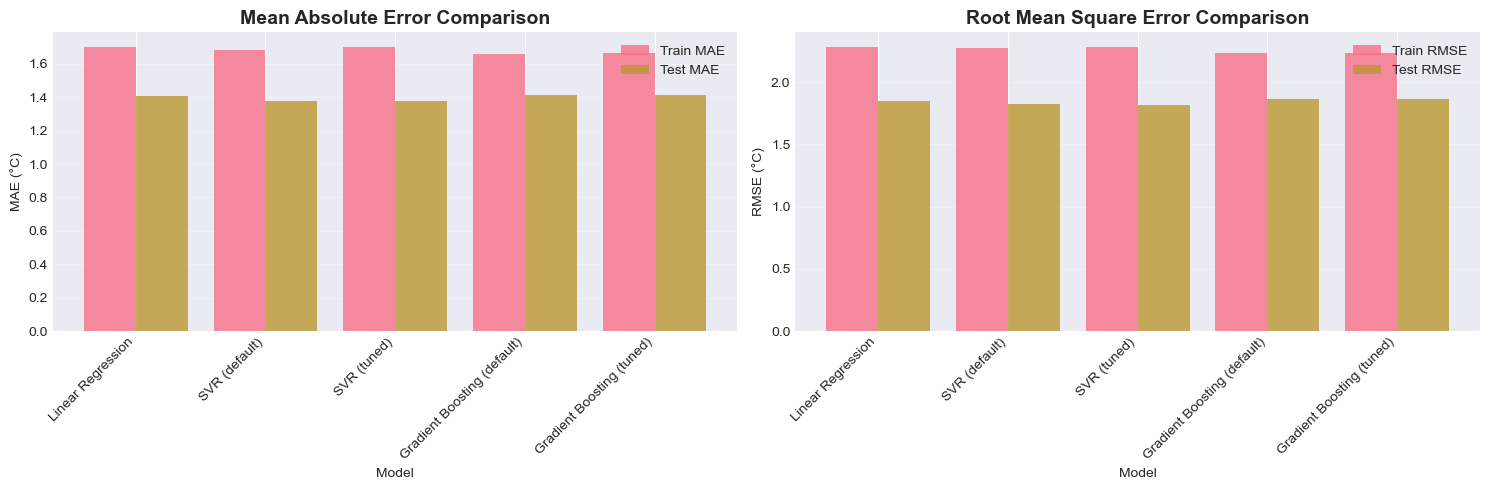

In [23]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# MAE comparison
x_pos = np.arange(len(results_df))
axes[0].bar(x_pos - 0.2, results_df['Train MAE'], 0.4, label='Train MAE', alpha=0.8)
axes[0].bar(x_pos + 0.2, results_df['Test MAE'], 0.4, label='Test MAE', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('MAE (°C)')
axes[0].set_title('Mean Absolute Error Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# RMSE comparison
axes[1].bar(x_pos - 0.2, results_df['Train RMSE'], 0.4, label='Train RMSE', alpha=0.8)
axes[1].bar(x_pos + 0.2, results_df['Test RMSE'], 0.4, label='Test RMSE', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('RMSE (°C)')
axes[1].set_title('Root Mean Square Error Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

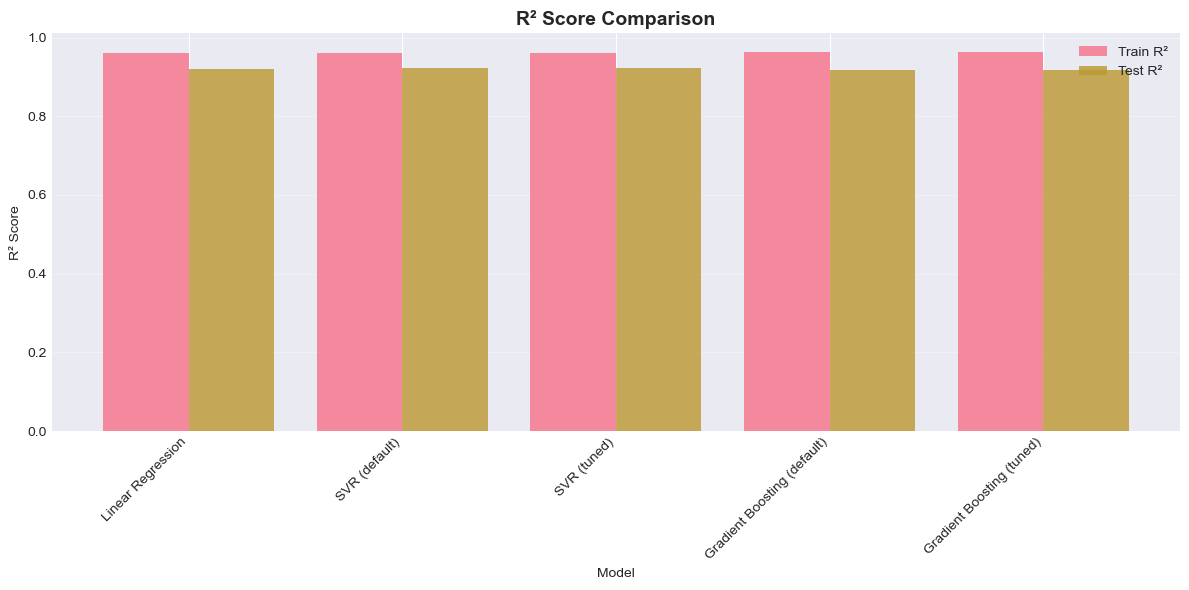

In [24]:
# R² Score comparison
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(results_df))
ax.bar(x_pos - 0.2, results_df['Train R²'], 0.4, label='Train R²', alpha=0.8)
ax.bar(x_pos + 0.2, results_df['Test R²'], 0.4, label='Test R²', alpha=0.8)
ax.set_xlabel('Model')
ax.set_ylabel('R² Score')
ax.set_title('R² Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
# ax.set_ylim([0.95, 1.0])  # Zoom in to see differences

plt.tight_layout()
plt.show()

In [25]:
# Calculate and display how much the best model improves forecast accuracy
# compared to the original raw forecast. This compares the RMSE of the raw forecast
# (using the forecasted temperature directly) to the RMSE of the best model
# on the test set, and reports both the absolute and percent improvement.

raw_rmse = np.sqrt(mean_squared_error(df_clean['temperature_2m (°C)'], df_clean['temperature_2m_previous_day1 (°C)']))
best_model_rmse = results_df.loc[best_model_idx, 'Test RMSE']
best_model_name = results_df.loc[best_model_idx, 'Model']
improvement = raw_rmse - best_model_rmse
percent_improvement = (improvement / raw_rmse) * 100

print(f"Raw forecast RMSE: {raw_rmse:.2f}°C")
print(f"{best_model_name} RMSE: {best_model_rmse:.2f}°C")
print(f"Absolute improvement: {improvement:.2f}°C")
print(f"Percent improvement: {percent_improvement:.1f}%")

Raw forecast RMSE: 2.23°C
SVR (default) RMSE: 1.82°C
Absolute improvement: 0.41°C
Percent improvement: 18.4%


## 10. Prediction Visualization

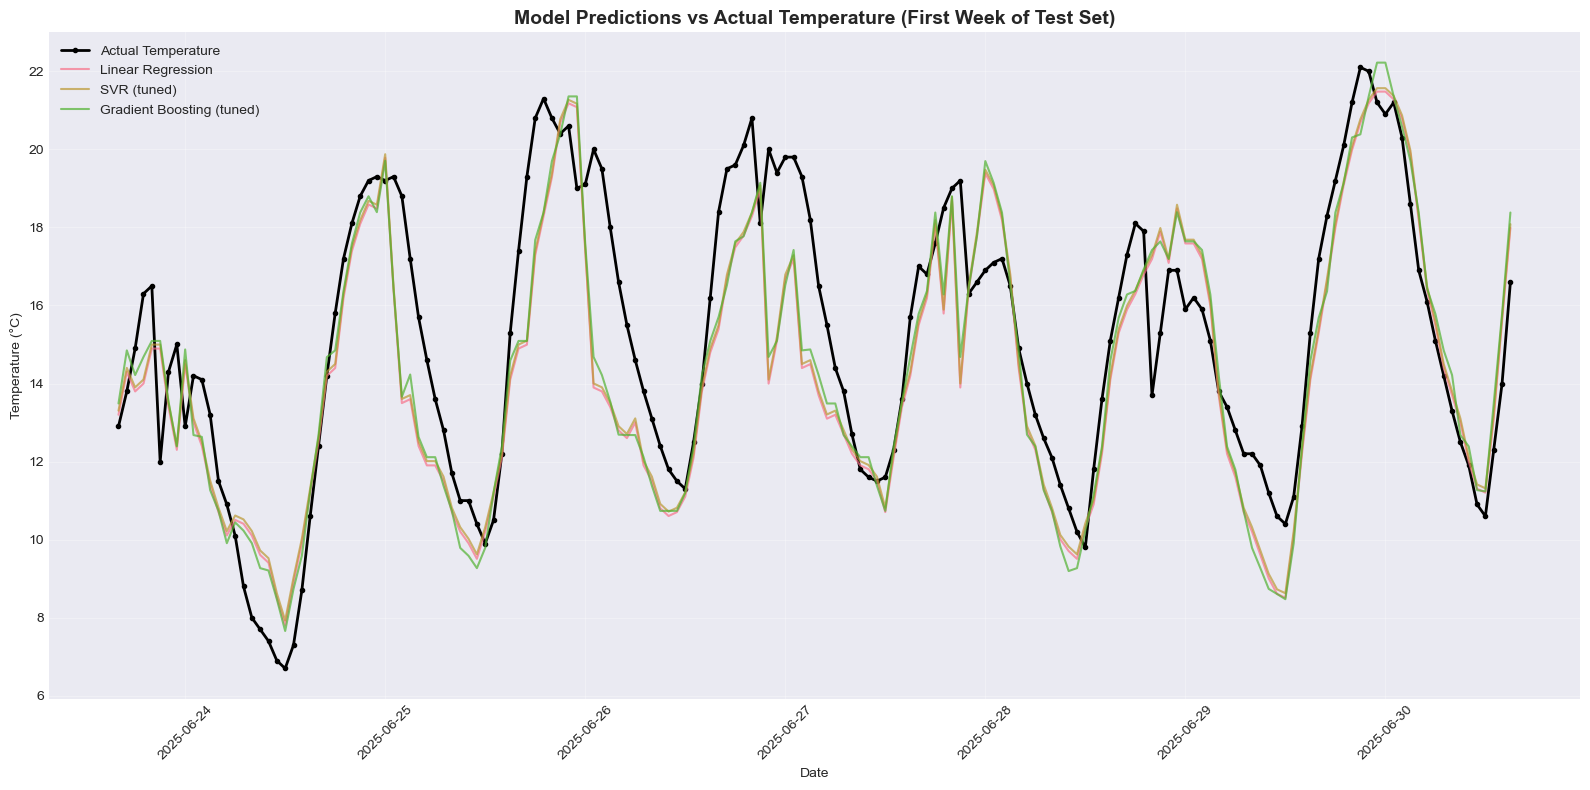

In [26]:
# After dropping NaNs, reset index to ensure alignment
df_clean = df_clean.reset_index(drop=True)


# When plotting predictions, use a direct range for the test set
sample_size = min(24 * 7, len(y_test))
sample_indices = range(sample_size)

# Get timestamps for test set (last len(y_test) rows after reset_index)
test_times = df_clean['time'].iloc[-len(y_test):].values

plt.figure(figsize=(16, 8))

plt.plot(test_times[sample_indices], y_test.values[sample_indices],
         label='Actual Temperature', linewidth=2, color='black', marker='o', markersize=3)

plt.plot(test_times[sample_indices], lr_results['predictions'][sample_indices],
         label='Linear Regression', alpha=0.7, linewidth=1.5)

plt.plot(test_times[sample_indices], svr_best_results['predictions'][sample_indices],
         label='SVR (tuned)', alpha=0.7, linewidth=1.5)

plt.plot(test_times[sample_indices], gb_best_results['predictions'][sample_indices],
         label='Gradient Boosting (tuned)', alpha=0.7, linewidth=1.5)

plt.title('Model Predictions vs Actual Temperature (First Week of Test Set)',
          fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

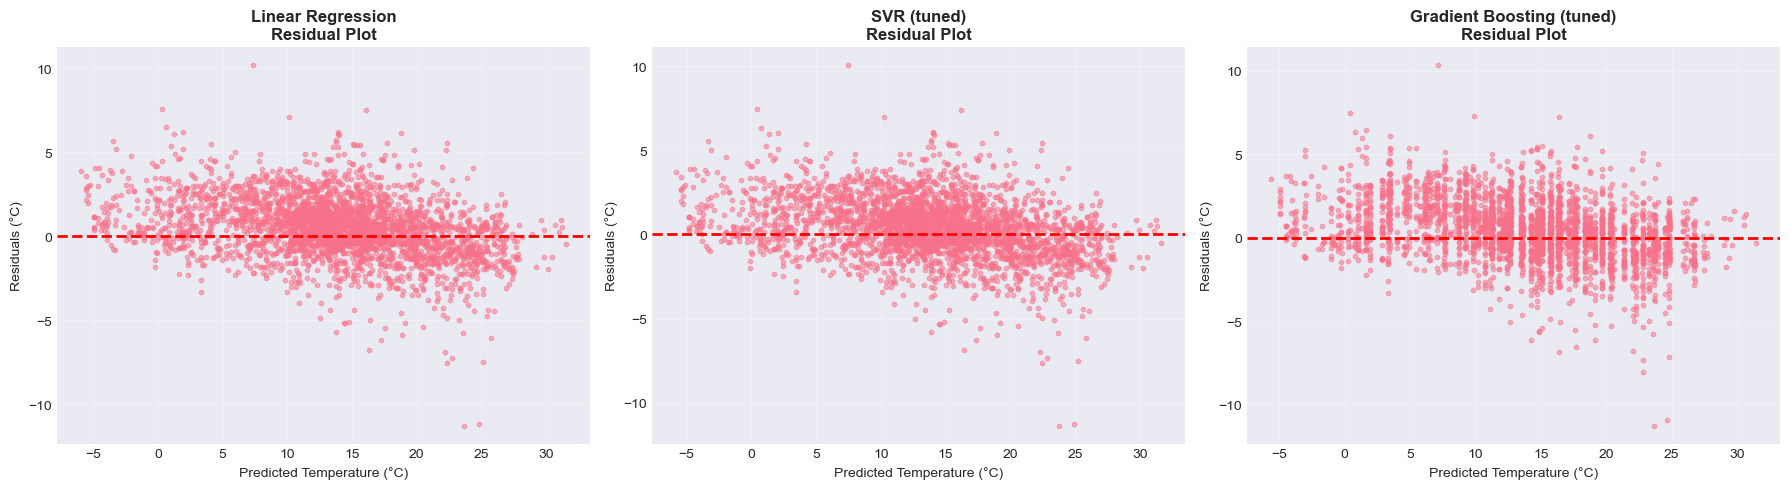

In [27]:
# Residual plots for best models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_to_plot = [
    ('Linear Regression', lr_results['predictions']),
    ('SVR (tuned)', svr_best_results['predictions']),
    ('Gradient Boosting (tuned)', gb_best_results['predictions'])
]

for idx, (name, predictions) in enumerate(models_to_plot):
    residuals = y_test.values - predictions
    
    axes[idx].scatter(predictions, residuals, alpha=0.5, s=10)
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Predicted Temperature (°C)')
    axes[idx].set_ylabel('Residuals (°C)')
    axes[idx].set_title(f'{name}\nResidual Plot', fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

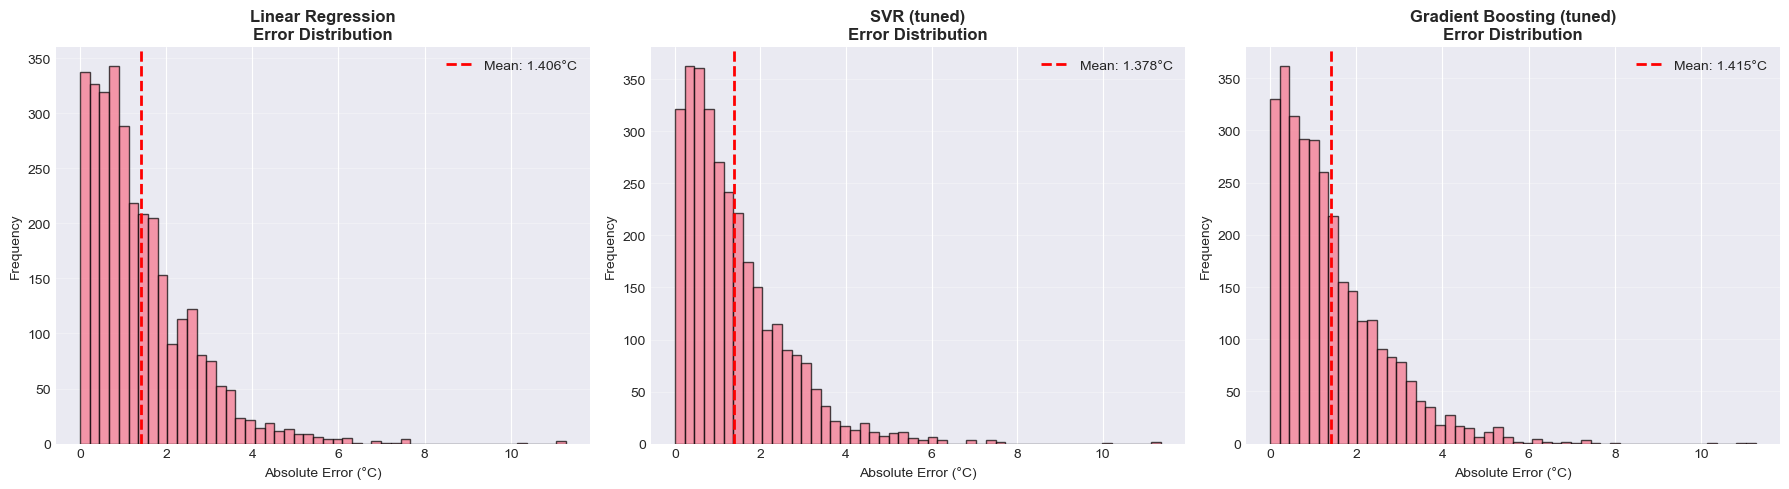

In [28]:
# Error distribution comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, predictions) in enumerate(models_to_plot):
    errors = np.abs(y_test.values - predictions)
    
    axes[idx].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].axvline(errors.mean(), color='red', linestyle='--', 
                     linewidth=2, label=f'Mean: {errors.mean():.3f}°C')
    axes[idx].set_xlabel('Absolute Error (°C)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{name}\nError Distribution', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 11. Feature Importance Analysis

In [29]:
# Feature importance for best model
if best_model_name.startswith('Gradient Boosting'):
    best_estimator = gb_grid.best_estimator_
    importances = best_estimator.feature_importances_
    importance_label = 'Feature Importance'
elif best_model_name.startswith('Linear Regression'):
    best_estimator = lr_model
    importances = np.abs(best_estimator.coef_)
    importance_label = 'Absolute Coefficient'
elif best_model_name.startswith('SVR'):
    print("Feature importance is not directly available for SVR models.")
    importances = None

if importances is not None:
    feature_importance = pd.DataFrame({
        'feature': [feature_col],
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    plt.barh(range(20), feature_importance['importance'].head(20))
    plt.yticks(range(20), feature_importance['feature'].head(20))
    plt.xlabel(importance_label)
    plt.title(f'Top 20 Most Important Features ({best_model_name})', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    display(feature_importance.head(10))

Feature importance is not directly available for SVR models.


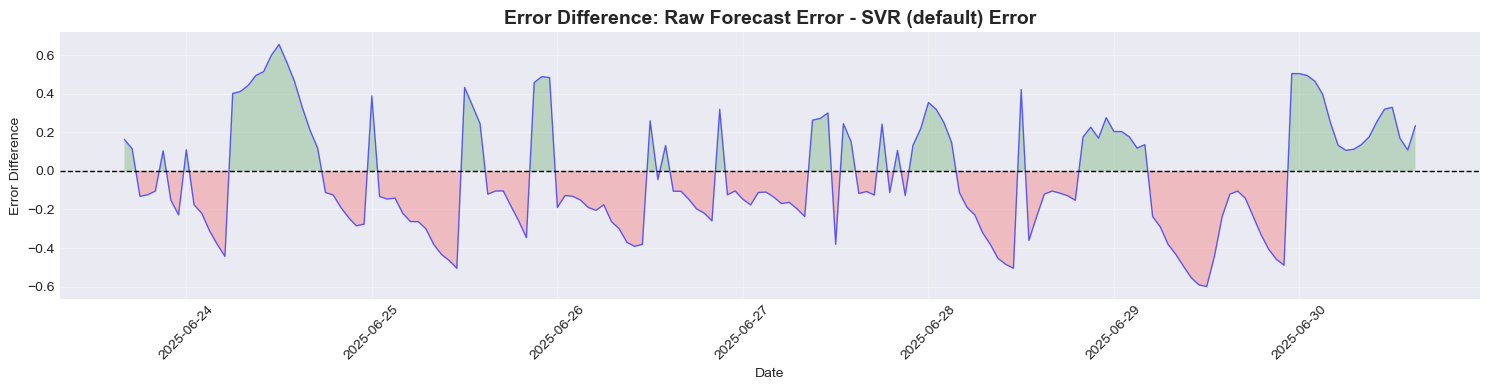

In [38]:
# Plot: Absolute error of raw forecast vs best model on test set (auto-select best model)

# Get test set indices (last len(y_test) rows after reset_index)
test_times = df_clean['time'].iloc[-len(y_test):].values
raw_forecast = df_clean['temperature_2m_previous_day1 (°C)'].iloc[-len(y_test):].values

# Map model names to their predictions
model_predictions = {
    'Linear Regression': lr_results['predictions'],
    'SVR (default)': svr_results['predictions'],
    'SVR (tuned)': svr_best_results['predictions'],
    'Gradient Boosting (default)': gb_results['predictions'],
    'Gradient Boosting (tuned)': gb_best_results['predictions'],
}

# Compute absolute errors
raw_error = np.abs(raw_forecast - y_test.values)
best_model_error = np.abs(model_predictions[best_model_name] - y_test.values)

# Compute the difference in absolute error
error_difference = raw_error - best_model_error

fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(test_times[sample_indices], error_difference[sample_indices],
    color='blue', alpha=0.6, linewidth=1)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_title(f'Error Difference: Raw Forecast Error - {best_model_name} Error',
         fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Error Difference')
ax.grid(True, alpha=0.3)

# Highlight where best model improves (positive = raw worse than model)
ax.fill_between(test_times[sample_indices], error_difference[sample_indices], 0,
        where=error_difference[sample_indices] >= 0,
        facecolor='green', alpha=0.2, interpolate=True)
ax.fill_between(test_times[sample_indices], error_difference[sample_indices], 0,
        where=error_difference[sample_indices] < 0,
        facecolor='red', alpha=0.2, interpolate=True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## 12. Conclusions and Summary

After testing out linear regression, SVR, and gradient boosting for predicting the next day’s temperature using just the forecasted value, we found that the default SVR model actually worked best on our test data. The forecast itself turned out to be a strong predictor, but we noticed it often underestimated the actual temperature. By applying a machine learning model, we managed to bring the RMSE down from 2.23°C (just using the raw forecast) to 1.82°C with SVR. That’s an improvement of about 0.41°C, or roughly 18%. Overall, even with just one main feature, these simple models did a pretty good job, and it shows that correcting for systematic bias in forecasts can make a noticeable difference.